<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

 # **[MIPT DL frameworks Autumn 2024](https://wiki.cogmodel.mipt.ru/s/mtai/doc/2024-nejrosetevye-frejmvorki-glubokogo-obucheniya-ZBGd69bxLd). Class 1: SuperResolution**

# Самостоятельная работа

# Задание

Реализовать обучение модели повышения размерности изображения (torch/jax - [пример](https://github.com/isaaccorley/pytorch-enhance)).
Обучающая выборка Div2K, тестовая Set5, Set14 (датасеты можно взять [тут](https://github.com/ilyazhara/BSRC-2023/tree/dev/bnn_competition/dataloaders)). В качестве результата приложить README.md, wandb отчет с графиками и репозиторий с кодом. Зачитывается первая уникальный результат. Метрики - PSNR, SSIM, LPIPS. Модели можно выбирать по бенчмарку https://paperswithcode.com/sota/image-super-resolution-on-set14-2x-upscaling. Оценка - 2 балла максимум.

Данные:

In [1]:
!pip install torch-enhance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00


In [2]:
import torch.optim as optim
import os
import json
import requests
import cv2
import zipfile

from tqdm import tqdm
import numpy as np
import shutil
import torch
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Model --- https://arxiv.org/pdf/1501.00092v3 SRCNN

In [30]:
def download_and_extract(url, path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    with tqdm(total=total_size, unit='B', unit_scale=True) as t:
        with open(os.path.basename(url), 'wb') as f:
            for data in response.iter_content(block_size):
                f.write(data)
                t.update(len(data))
    with zipfile.ZipFile(os.path.basename(url), 'r') as zip_ref:
        zip_ref.extractall(path)

def preprocess_dataset(input_folder, output_folder, size):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            h, w = img.shape[:2]
            pad_h = (size - h % size) % size
            pad_w = (size - w % size) % size
            img_padded = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

            for i in range(0, img_padded.shape[0], size):
                for j in range(0, img_padded.shape[1], size):
                    patch = img_padded[i:i+size, j:j+size]
                    output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.png"
                    output_path = os.path.join(output_folder, output_filename)
                    cv2.imwrite(output_path, patch)

def load_images(dataset_path):
    hr_images = []
    lr_images = []
    hr_folder = os.path.join(dataset_path, "image_SRF_2")

    hr_filenames = [f for f in os.listdir(hr_folder) if f.endswith("_SRF_2_HR.png")]

    for hr_filename in hr_filenames:
        hr_path = os.path.join(hr_folder, hr_filename)
        lr_filename = hr_filename.replace("_HR.png", "_LR.png")
        lr_path = os.path.join(hr_folder, lr_filename)

        hr_img = cv2.imread(hr_path)
        lr_img = cv2.imread(lr_path)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
        hr_images.append((hr_img, hr_filename))
        lr_images.append(lr_img)

    return hr_images, lr_images

In [4]:
download_and_extract("http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip", '/content/dataset')
download_and_extract("http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip", '/content/dataset')

preprocess_dataset('/content/dataset/DIV2K_train_HR', 'datasets/DIV2K_train', 96)
preprocess_dataset('/content/dataset/DIV2K_valid_HR', 'datasets/DIV2K_valid', 96)

100%|██████████| 3.53G/3.53G [03:23<00:00, 17.3MB/s]
100%|██████████| 449M/449M [00:26<00:00, 17.0MB/s]


In [16]:
class SRDataset(Dataset):
    def __init__(self, data_dir, lowres_size, scale, transform):
        self.data_dir = data_dir
        self.lowres_size = lowres_size
        self.scale = scale
        self.image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png'))]

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        high_res = cv2.imread(img_path)
        high_res = cv2.cvtColor(high_res, cv2.COLOR_BGR2RGB)

        highres_size = self.lowres_size * self.scale

        high_res = cv2.resize(high_res, (highres_size, highres_size), interpolation=cv2.INTER_CUBIC)
        low_res = cv2.resize(high_res, (self.lowres_size, self.lowres_size), interpolation=cv2.INTER_CUBIC)

        high_res = self.transform(high_res)
        low_res = self.transform(low_res)

        return low_res, high_res

In [17]:
from torch_enhance.models import SRCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRCNN(scale_factor=2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = SRDataset(data_dir='/content/datasets/DIV2K_train',
                                       lowres_size=48, scale=2,
                                       transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = SRDataset(data_dir='/content/datasets/DIV2K_valid',
                                     lowres_size=48, scale=2,
                                     transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [18]:
for epoch in range(3):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{3}'):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{3}], Loss: {running_loss/len(train_loader)}')

    model.eval()
    psnr_total = 0.0
    ssim_total = 0.0
    val_images = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            outputs_np = outputs.cpu().numpy().squeeze()
            targets_np = targets.cpu().numpy().squeeze()

            for i in range(outputs_np.shape[0]):
                data_range = outputs_np[i].max() - outputs_np[i].min()
                ssim_total += ssim(outputs_np[i], targets_np[i], channel_axis=0, data_range=data_range).item()
                psnr_total += psnr(outputs_np[i], targets_np[i], data_range=data_range).item()
                val_images += 1

    print(f'PSNR on val: {psnr_total/val_images}, SSIM on val: {ssim_total/val_images}')

Epoch 1/3: 100%|██████████| 4099/4099 [11:01<00:00,  6.19it/s]


Epoch [1/3], Loss: 0.07424204411209138


Validation: 100%|██████████| 521/521 [02:18<00:00,  3.76it/s]


PSNR on val: 16.138942789148924, SSIM on val: 0.4406247846216368


Epoch 2/3: 100%|██████████| 4099/4099 [09:25<00:00,  7.24it/s]


Epoch [2/3], Loss: 0.07141359635815298


Validation: 100%|██████████| 521/521 [02:04<00:00,  4.19it/s]


PSNR on val: 17.640813513302938, SSIM on val: 0.44912566992368713


Epoch 3/3: 100%|██████████| 4099/4099 [08:17<00:00,  8.24it/s]


Epoch [3/3], Loss: 0.07115153738400447


Validation: 100%|██████████| 521/521 [02:03<00:00,  4.23it/s]

PSNR on val: 17.331832508452305, SSIM on val: 0.45554636401077003


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
def validate_model(model, dataset_path, device):
    hr_images, lr_images = load_images(dataset_path)
    psnr_values = []
    ssim_values = []

    os.makedirs("sr_results", exist_ok=True)

    model.eval()
    with torch.no_grad():
        for (hr_img, hr_filename), lr_img in zip(hr_images, lr_images):
            hr_shape = hr_img.shape
            h, w, _ = lr_img.shape
            patch_size = 48

            pad_h = (patch_size - h % patch_size) % patch_size
            pad_w = (patch_size - w % patch_size) % patch_size
            lr_img_padded = np.pad(lr_img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')

            sr_img = np.zeros((lr_img_padded.shape[0]*2, lr_img_padded.shape[1]*2, 3), dtype=np.uint8)

            for y in range(0, lr_img_padded.shape[0], patch_size):
                for x in range(0, lr_img_padded.shape[1], patch_size):
                    lr_patch = lr_img_padded[y:y+patch_size, x:x+patch_size]
                    lr_patch = torch.from_numpy(lr_patch.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
                    lr_patch = (lr_patch / 127.5) - 1
                    sr_patch = model(lr_patch).clip(-1, 1)
                    sr_patch = (sr_patch.squeeze().cpu().numpy().transpose(1, 2, 0) * 127.5 + 127.5).astype(np.uint8)
                    sr_img[y*2:y*2+sr_patch.shape[0], x*2:x*2+sr_patch.shape[1]] = sr_patch

            sr_img = sr_img[:hr_shape[0], :hr_shape[1]]

            psnr_value = psnr(hr_img, sr_img)
            ssim_value = ssim(hr_img, sr_img, channel_axis=2)

            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

            combined_img = np.concatenate((hr_img, sr_img), axis=1)
            output_filename = os.path.join("sr_results", f"sr_hr_{dataset_path.split('/')[-1]}_{os.path.basename(hr_filename)}")
            cv2.imwrite(output_filename, cv2.cvtColor(combined_img, cv2.COLOR_RGB2BGR))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Dataset: {os.path.basename(dataset_path)}')
    print(f"PSNR: {avg_psnr:.2f} dB")
    print(f"SSIM: {avg_ssim:.4f}")

validate_model(model, "/content/drive/MyDrive/Colab Notebooks/datasets/Set5/Set5", device)
validate_model(model, "/content/drive/MyDrive/Colab Notebooks/datasets/Set14/Set14", device)

Dataset: Set5
Average PSNR: 23.15 dB
Average SSIM: 0.7101
Dataset: Set14
Average PSNR: 22.65 dB
Average SSIM: 0.6712


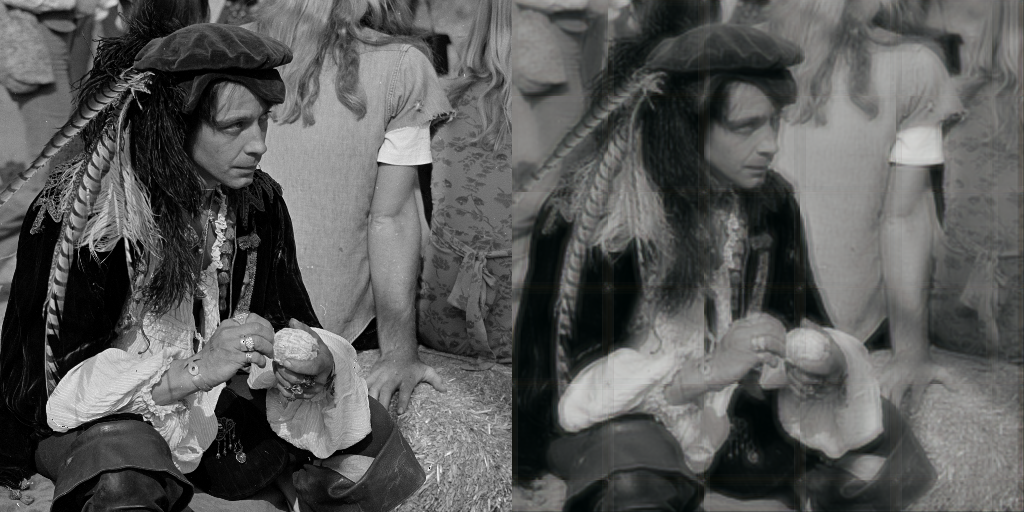

In [35]:
from PIL import Image
from IPython.display import display

img_path = '/content/sr_results/sr_hr_Set14_img_010_SRF_2_HR.png'
img = Image.open(img_path)

display(img)